# Hotel reviews classification using Arabic ULMFIT model
### You can get this dataset from https://github.com/elnagara/HARD-Arabic-Dataset .
This dataset contains 93700 hotel reviews in Arabic language. The hotel reviews were collected from Booking.com website during June/July 2016. The reviews are expressed in Modern Standard Arabic as well as dialectal Arabic. 
##### *Citation*:
> Elnagar A., Khalifa Y.S., Einea A. (2018) Hotel Arabic-Reviews Dataset Construction for Sentiment Analysis Applications. 
In: Shaalan K., Hassanien A., Tolba F. (eds) Intelligent Natural Language Processing: Trends and Applications. 
Studies in Computational Intelligence, vol 740, pp: 35-52. Springer International Publishing. 
doi="10.1007/978-3-319-67056-0_3. url="https://doi.org/10.1007/978-3-319-67056-0_3"

For more information about ULMFIT see [Paper](https://arxiv.org/abs/1801.06146) & [Blog post](http://nlp.fast.ai/).

### Using our pretrained Arabic ULMFIT language model we do the following:
1- Preprocess our dataset and get it ready for use in the coming steps by creating a language model databunch & classifer databunch.

2- Load our language model with pretrained weights then fine-tune it to our dataset.

3- Create a classifier on top of the encoder of the language model.

In [7]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [3]:
from fastai.text import *
import path
import copy

In [1]:
#Latest dev version of fastai in order to get some fixes for QRNNs
import fastai; fastai.__version__

'1.0.51.dev0'

In [6]:
data_path = Path('data')
lm_path = Path('.')

### 1- Pre-processing our Dataset :

**This notebook uses the balanced reviews file (50 % neg, 50% pos),  you can find the notebook that uses the unbalanced reviews in the same github repo.**

In [10]:
balanced_df = pd.read_csv(data_path/'balanced-reviews.txt',delimiter='\t',encoding='utf_16_le')

In [11]:
balanced_df.head()

,no,Hotel name,rating,user type,room type,nights,review
0,2,فندق 72,2,مسافر منفرد,غرفة ديلوكس مزدوجة أو توأم,أقمت ليلة واحدة,“ممتاز”. النظافة والطاقم متعاون.
1,3,فندق 72,5,زوج,غرفة ديلوكس مزدوجة أو توأم,أقمت ليلة واحدة,استثنائي. سهولة إنهاء المعاملة في الاستقبال. ل...
2,16,فندق 72,5,زوج,-,أقمت ليلتين,استثنائي. انصح بأختيار الاسويت و بالاخص غرفه ر...
3,20,فندق 72,1,زوج,غرفة قياسية مزدوجة,أقمت ليلة واحدة,“استغرب تقييم الفندق كخمس نجوم”. لا شي. يستحق ...
4,23,فندق 72,4,زوج,غرفة ديلوكس مزدوجة أو توأم,أقمت ليلتين,جيد. المكان جميل وهاديء. كل شي جيد ونظيف بس كا...


In [12]:
balanced_df.shape

(105698, 7)

*Create A held-out test dataset using 10% of our full dataset. and drop it from the full dataset.*

In [13]:
test_df = balanced_df.sample(frac = .1 ,replace=False,random_state = 42)

In [14]:
balanced_df = balanced_df.drop(test_df.index)
balanced_df.shape

(95128, 7)

*Create 2 csv files containing our train/valid and our test datasets.*

In [15]:
test_df.to_csv(data_path/'balanced_reviews_test.csv',index=False)

In [16]:
balanced_df.to_csv(data_path/'balanced_reviews_train.csv',index=False)

In [7]:
balanced_train_df = pd.read_csv(data_path/'balanced_reviews_train.csv')

In [8]:
balanced_test_df = pd.read_csv(data_path/'balanced_reviews_test.csv')

* Create a Language model databunch that does all the necessary preprocessing like tokenization and numericalization.

* All the text in the dataset is concatenated and the labels are ignored. Instead, the target is the next word in the sentence.

* We also create a validation set that is 10% of our full dataset (80% train 10% valid 10% test).

In [20]:
reviews_lm_data = (TextList.from_df(balanced_train_df,cols=['review'])
                   .split_by_rand_pct(.1)
                   .label_for_lm()
                   .databunch(bs=64))

In [21]:
reviews_lm_data.show_batch()

idx,text
0,فيه صيانه والله اعلم xxbos ممتاز . موقع الفندق ونظافته والاطلاله على البحر وجزيرة النور التي تحتوي على الفراشات وكذلك قربه من المسجد والممشى توفر المواقف بجانب الفندق وخدمة صف السيارات . المسبح كان مغلق للصيانه المواقف تحتاج الى مظلات xxbos “ جيدجداً ” . الافطار جيد والسرير ممتاز ومريح واطلالة الغرفة رائعه . فرش ارضية الغرفه xxbos “ فندق ممتاز ” . الاثاث ، النظافه . xxbos “ الراحة
1,جدا ” . . xxunk وجود وأي فأي فري مع انا فتدق ثلاثه نجوم وفنادق نجمه ونجمتين يوجد لديهم وأي فأي فري ومواقف فري xxbos “ xxunk عليه ” . لا شئ . كل شئ xxbos “ الفندق سيّء جدا ” . لا شئ اعجبني على الإطلاق . كل شي في الفندق xxbos “ لم يعجبني ” . فقط السرير . كل شيء عليها ضمان ضمان و كل شيء عليه
2,به ويحتاج إلى تنوع أكثر . لايوجد خدمة انترنيت مجاني بالرغم من أن اغلب الفنادق اصبحت توفر هذه الخدمة ، أيضاً الشطافات في الحمامات كانت صدئة وغير نظيفة ، لم أشعر بالراحة في الغرفة أثناء النوم ليلاً كان هناك شي غريب بها . xxbos “ فندق ذو ملحقات ممتازه ” . المساحة وملحقات الفندق من الحديقة والمسابح والمطعم الخارجي . الغرفة لاترقى بمستوى الفندق ويوجد بالجدران xxunk بالصبغ يدل على
3,"xxmaj please xxunk the city map to xxmaj see what i mean . xxmaj the breakfast "" we try it xxunk only from 7 "" . xxbos “ فندق عادي او اقل بسعر عالي جدا ” . . بهو الفندق مزدحم تماما ولا يوجد اي xxunk الفندق غير متاح xxunk عوازل بين الغرف لدرجة احساسي بأصوات الغرف حولي كأنهم معي في نفس الغرفة . الغرفة صغيرة xxunk الطعام محدود للغاية"
4,يعجبني سوا قربه من الحرم فقط الباقي تم الاشاره له اعلاه xxbos رائع . . لايوجد موقف سيارات xxbos استثنائي . . النت ما يشتغل بالغرف الا نادر و اذا اشتغل بطيء جداً xxbos “ xxunk غير موفقه ” . قربه من الحرم . الغرفه ضيقه ودورة المياه صغيره جداوالسرير غير مريح xxbos “ ممتاز جداً ” . ممتاز جداً وقريب من الحرم . xxbos “ لايستحق تقييم الفندق سيئ


*Save our databunch so we can load it instantly later if we want.*

In [22]:
reviews_lm_data.save('reviews_lm')

In [23]:
reviews_lm_data = load_data(lm_path,'reviews_lm')

* Create a classification databunch that does all the necessary preprocessing like tokenization and numericalization.
* We map the rating to labels ('pos' or 'neg').
* We also pass the vocabulary (mapping from ids to words) that we want to use to ensure that our classification databunch will use the same dictionary as our language model databunch.

In [25]:
label_for_reviews = lambda x: 'neg' if(x[1] < 3) else 'pos'

In [26]:
reviews_cls_data = (TextList.from_df(balanced_train_df,cols=['review','rating'],vocab=reviews_lm_data.train_ds.vocab)
                   .split_by_rand_pct(.1)
                   .label_from_func(label_for_reviews)
                   .databunch(bs=64))

In [27]:
reviews_cls_data.show_batch()

text,target
xxbos “ فندق وادارة لايهمه الزبون وفريق متعالي على لاشئ ” . كان لدي حجزين احدهم لاربع ايام والاخر بعدها بيوم لاربع ايام وحين وصل الفندق مع والدتي والعائله فاجأوني بأن الحجز الاول تم الغاءه دون التواصل معي او الاتصال من الفندق او من بوكينج وعذرهم xxunk لك ايميل xxunk مساء يوم الحجز وقد وصلت الفندق xxunk وقالوا العمليه معلقه ولكن حجزك الاخر للعائله الاخرى غدا تم اعتماده . ولكن,neg
xxbos “ رديء للغ xxrep 7 ا يه xxunk اسأل مجرب ” . لا شي . الفندق غير مؤهل للسكن من ك xxrep 5 ا فة النواحي الاثاث قديم والتلفزيون فيه xxunk او 3 xxunk غير عربيات ياخي ناس جايه تجلس فترات xxunk خاصه xxunk طالعه برا الفندق تريد اتابع شي xxunk قنوات هنود xxunk .. و ملئ بالحشرات وخاصه السرير ظهور حشرات لاترى xxunk وانت ن xxrep 5 ا,neg
"xxbos “ حضرت للعمرة انا xxunk ” . مدير الفندق رجل محترم xxunk حين لم يخدمنا الموظفين , xxunk السحور في مطعم المطبخ كان رخيص xxunk xxunk ريال ) لكن افضل شي كان طبخ الطباخ , طلبنا مقابلته xxunk جدا جدا على اتقان طبخه xxunk وذكر انه تونسي الجنسيه xxunk مالك الفندق xxunk على الطباخ وطلبنا xxunk , ميزة الفندق انه اقرب الفنادق لباصات النقل الجماعي في محبس الجن ,",neg
xxbos “ تجربه لم تكن سيئه ولكن لن اكررها ” . ١ / المكان جميل على البحر ٢ / المواقف مريحة وواسعه تقف امام xxunk / تعامل الموظفين xxunk / حجزي كان مؤكد عن طريق بوكينق فله بغرفه نوم واحدة لكن لما وصلت قالوا لي الفلل بغرفة نوم واحده فل xxunk فله بغرفتين بنفس السعر .. ( ميزة بالنسبه لي لكن هذا يعني عدم xxunk بالحجز المؤكد ) اكثر شي,neg
xxbos “ تجربة فاشلة xxunk ” . لا يوجد . التعامل سيئ عدم الرد على النزلاء التجاهل والتطنيش يتم الاتصال اكثر من مرة ولايوجد رد انعدام الادب لديهم وفي الافطار واجهت اكثر من موقف ولم اصعد الموضوع يتم اخذ اكواب القهوة من على الطاولة بدون استاذان مع العلم بوجود طاولات غير شاغرة الانتظار منا الجلوس والسماح xxunk بالذهاب للبوفية ضعف وقلة اصناف الافطار لايوجد خدمة راقية التاخر في ارسال الملابس,neg


In [28]:
reviews_cls_data.save('reviews_cls')

In [29]:
reviews_cls_data = load_data(lm_path,'reviews_cls')

## 2- Fine-tune our LM to our Dataset:

In [30]:
pretrained_lm_fname = 'new_lm'
pretrained_itos_fname = 'itos'

* We will create a uni-directional [QRNN] (https://arxiv.org/abs/1611.01576) that will load our pre-trained language model weights stored in `new_lm.pth` and also load  `itos.pkl`  which contains our id to token mapping.
* We also pass it our language model databunch which we will fine-tune our language model to.

In [31]:
emb_sz:int = 400
nh: int = 1550
nl: int = 3

qrnn_config = copy.deepcopy(awd_lstm_lm_config)
dps = dict(output_p=0.25, hidden_p=0.1, input_p=0.2, embed_p=0.02, weight_p=0.15)
qrnn_config.update({'emb_sz':emb_sz, 'n_hid':nh, 'n_layers':nl, 'pad_token':1, 'qrnn':True})
qrnn_config

{'emb_sz': 400,
 'n_hid': 1550,
 'n_layers': 3,
 'pad_token': 1,
 'qrnn': True,
 'bidir': False,
 'output_p': 0.1,
 'hidden_p': 0.15,
 'input_p': 0.25,
 'embed_p': 0.02,
 'weight_p': 0.2,
 'tie_weights': True,
 'out_bias': True}

In [32]:
lm_learner = language_model_learner(reviews_lm_data,AWD_LSTM,pretrained=False,config=qrnn_config, model_dir=lm_path,drop_mult=.3,pretrained_fnames=(pretrained_lm_fname,pretrained_itos_fname))

In [33]:
lm_learner.lr_find(start_lr = slice(10e-7,10e-5),end_lr=slice(0.1,10))

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


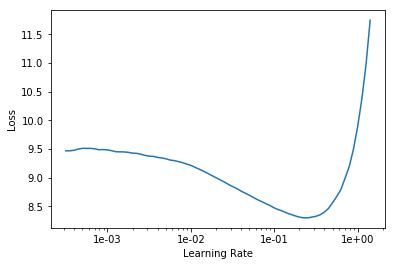

In [34]:
lm_learner.recorder.plot(skip_end=10)

In [124]:
lm_learner.metrics = [accuracy,Perplexity()]

*We train our model starting from the last layer then unfreezing the model and training the entire network*

In [35]:
lm_learner.fit_one_cycle(1,2e-2)

epoch,train_loss,valid_loss,accuracy,time
0,5.836286,5.239108,0.219654,01:04


In [36]:
lm_learner.save('balanced-stage1-lm-1epoch')

In [37]:
lm_learner.unfreeze()

In [38]:
lm_learner.fit_one_cycle(2,2e-2)

epoch,train_loss,valid_loss,accuracy,time
0,4.961680,4.750681,0.253110,01:13
1,4.581797,4.533260,0.269498,01:13


In [39]:
lm_learner.save('balanced-stage2-lm-2epoch')

In [40]:
lm_learner.fit_one_cycle(2,2e-2)

epoch,train_loss,valid_loss,accuracy,time
0,4.685013,4.612954,0.261522,01:13
1,4.376598,4.479545,0.273434,01:13


In [41]:
lm_learner.save('balanced-stage2-lm-4epoch')

* To evaluate our language model, we run the `Learner.predict` method specifying the number of words we want it to guess.
* We can see that the predicted words don't make much sense but are coherent and follow basic grammer thanks to our language model.

In [47]:
lm_learner.predict('الغرفة جميلة',n_words=10)

'الغرفة جميلة والأفطار جيد والسرير غير مريح والحمامات مفروشة فقط . الماء'

*We save the language model encoder to use it for classification in the next step.*

In [48]:
lm_learner.save_encoder('balanced-stage2-lm-enc')

### 3- Creating the classifer:

*We now use the classifer databunch we created earlier to build a classifier with our fine-tuned encoder.* 

In [55]:
qrnn_cls_config = copy.deepcopy(awd_lstm_clas_config)
dps = dict(output_p=0.25, hidden_p=0.1, input_p=0.2, embed_p=0.02, weight_p=0.15)
qrnn_cls_config.update({'emb_sz':emb_sz, 'n_hid':nh, 'n_layers':nl, 'pad_token':1, 'qrnn':True})
qrnn_cls_config

{'emb_sz': 400,
 'n_hid': 1550,
 'n_layers': 3,
 'pad_token': 1,
 'qrnn': True,
 'bidir': False,
 'output_p': 0.4,
 'hidden_p': 0.3,
 'input_p': 0.4,
 'embed_p': 0.05,
 'weight_p': 0.5}

In [56]:
clas_learner = text_classifier_learner(reviews_cls_data,AWD_LSTM,config=qrnn_cls_config,model_dir=lm_path,drop_mult=.5)

In [57]:
clas_learner.load_encoder('balanced-stage2-lm-enc')

In [58]:
clas_learner.lr_find(start_lr = slice(10e-7,10e-5),end_lr=slice(0.1,10))

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


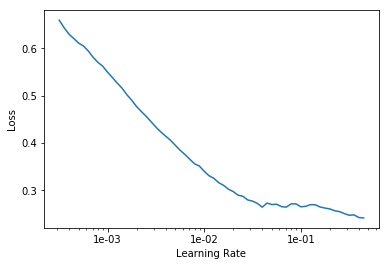

In [59]:
clas_learner.recorder.plot(skip_end=10)

*Again We train our model starting from the last layer then unfreezing the model and training the entire model
we use `F-score` as a metric to compare our results to the cited paper.*

In [60]:
clas_learner.metrics = [accuracy,FBeta()]

In [61]:
clas_learner.fit_one_cycle(1,2e-3)

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.074566,0.002796,0.999054,0.999627,00:28


In [62]:
clas_learner.save('balanced-stage1-cls-1epoch')

In [63]:
clas_learner.unfreeze()

In [64]:
clas_learner.fit_one_cycle(2,2e-3)

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.002978,0.000000,1.000000,1.000000,01:12
1,0.001776,0.000000,1.000000,1.000000,01:15


In [65]:
clas_learner.save('balanced-stage2-cls-2epoch')

*We can test our classifier by giving it a review and see the predicted sentiment and its propablity.*

In [66]:
text = 'لن اكرر تجربتي مع هذا الفندق'

In [68]:
clas_learner.predict(text)

(Category neg, tensor(0), tensor([0.9099, 0.0901]))

In [76]:
clas_learner.show_results()

text,target,prediction
xxbos “ xxmaj the beach and xxunk are the only good things in this hotel ” . xxmaj the beach and xxunk are the only good things in this hotel . xxmaj the swimming pool is good as well . xxmaj the beach is safe and clean . الشيء الوحيد الجيد في هذا المنتجع هو شاطئ البحر و المنقذين حيث أنهم xxunk xxunk xxmaj first of all there is no,neg,neg
xxbos “ استمتع .. إنه مناسب ” . * موقع الفندق ممتاز .. على طريق الكورنيش .. على الجانب الآخر من الطريق يوجد جميع أنواع الخدمات التي يحتاجها المسافر من : بقالات ، ومطاعم ، ومغاسل ملابس ، وحلاقين ... إلخ .. كل ما عليك أن تقطع الطريق ( ملاحظة الطريق أمام الفندق - الجانب xxunk مزدحم في أوقات xxunk .. أما القهوة الشعبية ( وهي مطعم شعبي أيضًا ),pos,pos
xxbos “ الفندق سيئ xxunk الكلمة ” . . اولا : موقع الفندق لا يوجد به شارع ، تقريبا مسافه كيلو ترابي . ٢- الاستقبال جدا جاف ، xxunk خدمه فاشلة . ٣- عندما ذهبنا للغرفه xxunk اغراضنا وعندما رجعنا وجدنا ان بعض من العصائر قد اخذت من الثلاجة ٤- اليوم الثاني عند تنظيف الغرفه ، الموظفين سرقو اغراضنا ( اشترينا اغراض بسيطة مثل xxunk وعصائر وبعض من xxunk xxunk,neg,neg
xxbos “ تجربة سيئة xxunk غير xxunk ” . تقيمي سيكون للادارة لا للمسافرين xxunk مختلف ، xxunk تم حجز غرفة مزدوجة في فرع الفلاح وفي عصر يوم الحجز يتصل بي الفندق اخ مصري ويقول بأن الغرفة ليست جاهزة xxunk xxunk حجزك للفرع الاخر الحسن بن علي فهو اجدد فرع وسيكون بـ 200 ريال نفس القيمة الغرفة التي تم حجزها وانا وافقت xxunk مني حيث انها ستكون استراحة لاكمال سفر,neg,neg
xxbos مخيب للأمل . . ١ / الافطار xxunk / كذالك يسون حركة xxunk تدل على عدم ثقه بالنزيل ، عند وصولك للافطار يتم ادخالك مباشرة دون التاكد من رقم الغرفة واستغربت الحركه هذي وبعد جلوسك يتم جرد الافراد xxunk وتقييم الاعمار من قبل الجرسون استغربت من الحركه هذي قلت لمدير المطعم ليش الحركه هذي الفنادق يتم التسجيل عند مدخل البوفيه والعدد قال عشان ما xxunk زحام عند المدخل قلت,neg,neg


*We create a temp databunch containg our held-out test dataset to validate our classifer.*

In [69]:
balanced_all_df = pd.concat([balanced_train_df,balanced_test_df])
balanced_all_df.shape

(105698, 7)

In [70]:
reviews_cls_test_data = (TextList.from_df(balanced_all_df,cols=['review','rating'],vocab=reviews_lm_data.train_ds.vocab)
                   .split_by_idx(balanced_test_df.index)
                   .label_from_func(label_for_reviews)
                   .databunch(bs=64))

In [77]:
#Validate returns (error rate , accuracy , F-Score)
clas_learner.validate(reviews_cls_test_data.valid_dl)

[5.498965e-07, tensor(1.), tensor(1.)]